In [ ]:
#buylytics- customer_segment_analysis
#-- based_on_RFM_calculation

In [ ]:
#CartIQ-customer_segment_analysis
#-- based_on_

In [43]:
"""
use the require  modules
"""
# Data processing
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine learning (clustering)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Statistical analysis
from scipy.stats import zscore

# File Input and Output
import os



---



* `pandas` → Load and work with table data (like Excel or CSV files).
* `numpy` → Do math operations like rounding and calculations.
* `datetime`, `timedelta` → Work with dates (used to calculate Recency).
* `matplotlib.pyplot` → Draw basic graphs (bar, line, scatter).
* `seaborn` → Create good-looking charts easily.
* `plotly.express` → Make interactive charts (hover, zoom, 3D).
* `StandardScaler` → Normalize values so they’re on the same scale.
* `KMeans` → Group customers into segments like VIP, Loyal, etc.
* `silhouette_score` → Check how well customers are grouped (cluster quality).
* `zscore` → Standardize values using Z-score (mean and standard deviation).
* `os` → Work with files and folders on your system.

---




In [ ]:
import pandas as pd
data=pd.read_excel('online_retail_II.xlsx')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [42]:
"""
step -1 load and clean the dataset
"""
data.dropna(subset=['Customer ID'], inplace=True)
data = data[data['Quantity'] > 0]
data.rename(columns={'Price': 'UnitPrice'}, inplace=True)
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']
data.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country,TotalSpend
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


This code performs essential data cleaning before analysis:

 -->Removes rows with missing Customer ID.

-->Filters out records with non-positive Quantity (e.g., returns or errors).

 -->Renames the Price column to UnitPrice for clarity.

-->Creates a new column TotalSpend by multiplying Quantity × UnitPrice.

The cleaned data is now ready for RFM analysis.

In [ ]:
"""
# step 2 : calculating the rmf values
"""
# timedelta is used to add or subract the dates to the current date
from datetime import timedelta


# Define snapshot date
snapshot_date = data['InvoiceDate'].max() + timedelta(days=1)

# RFM calculation
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSpend': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()



,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


R – Recency: How recently a customer made a purchase.

F – Frequency: How often a customer makes purchases.

M – Monetary: How much money a customer has spent.

**Purpose of RFM Analysis:**
RFM analysis is a marketing technique used to segment customers based on their purchasing behavior.
It helps businesses identify which customers are the most valuable and which ones need attention.

In [ ]:
"""
step -3 : Normalize the data for the cluestring
"""
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm_normalized = scaler.fit_transform(rfm)
rfm_normalized = pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)
rfm_normalized.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.439678,0.049020,0.001068
12347.0,0.005362,0.004902,0.003790
12348.0,0.195710,0.000000,0.000636
12349.0,0.112601,0.009804,0.007650
12351.0,0.026810,0.000000,0.000862


Normalization (or scaling) adjusts the values so that all R, F, M scores are on the same scale (like 0–1 or 1–5).

**Problem Without Normalization**
*If we skip normalization:*

Monetary (₹ values) might dominate the analysis because of its larger range.

Recency (in days) might look too small and contribute less.

The model may give biased results toward one variable.



In [ ]:
#step:apply k_means clustring
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


We use K-Means to group customers into segments based on their RFM scores.
It helps you automatically find patterns or clusters in customer behavior.
--> This line imports Matplotlib, a library for creating graphs.

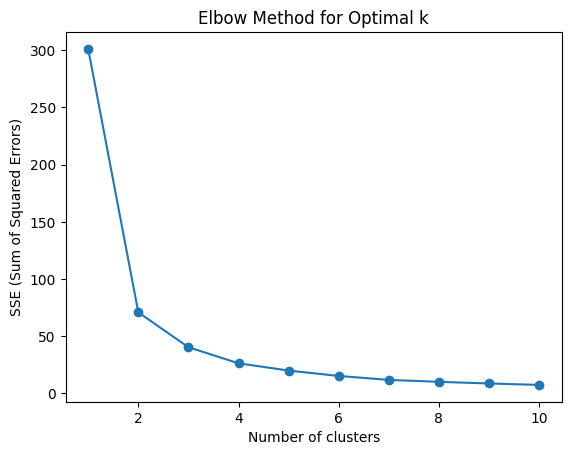

In [ ]:
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal k')
plt.show()


This code applies the Elbow Method to find the optimal number of clusters (k) for K-Means on the normalized RFM data.
It calculates the Sum of Squared Errors (SSE) for cluster values from 1 to 10.
The elbow point on the plotted graph indicates the best k, where adding more clusters doesn't significantly reduce the SSE.
This helps choose the right number of customer segments for effective RFM-based clustering.

In [49]:

k = 4  # You can change this based on the elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
rfm_normalized['Cluster'] = kmeans.fit_predict(rfm_normalized)


This code applies K-Means clustering with k = 4 (as chosen from the Elbow plot) on the normalized RFM data.
The fit_predict() function trains the model and assigns each customer to one of the 4 clusters.
A new column called 'Cluster' is added to rfm_normalized, indicating each customer's segment based on their RFM values.
This allows further analysis and visualization of customer groups.

In [50]:
rfm['Cluster'] = rfm_normalized['Cluster']
rfm.head()


,index,Customer ID,Recency,Frequency,Monetary,Cluster,Segment
0,0,12346.0,165,11,372.86,NaN,At-Risk
1,1,12347.0,3,2,1323.32,NaN,Loyal
2,2,12348.0,74,1,222.16,NaN,VIP
3,3,12349.0,43,3,2671.14,NaN,Loyal
4,4,12351.0,11,1,300.93,NaN,Loyal


This code adds the cluster labels from the rfm_normalized DataFrame back to the original rfm DataFrame.
So now, the original RFM data (with actual Recency, Frequency, Monetary values) includes a new Cluster column, showing which group each customer belongs to.
The rfm.head() displays the first 5 rows so you can verify the added cluster assignments.

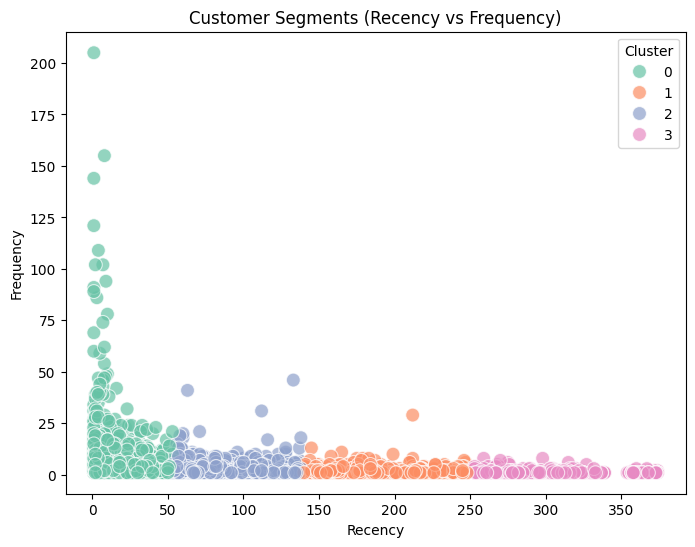

In [ ]:
#2D Cluster Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Frequency',
    hue='Cluster',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title("Customer Segments (Recency vs Frequency)")
plt.show()


This code creates a 2D scatter plot to visualize customer segments based on Recency and Frequency.
Each point represents a customer, and colors indicate different clusters from K-Means.
It helps identify patterns in customer behavior, like who buys frequently and how recently.

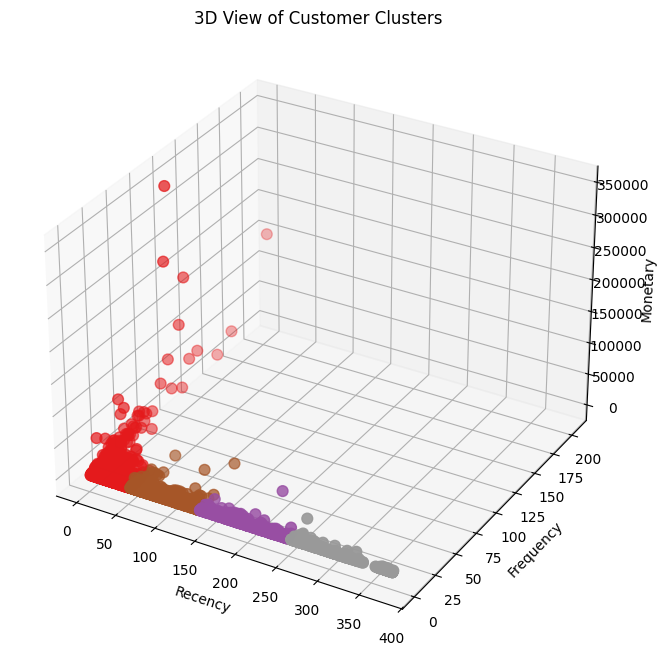

In [ ]:
#3D Cluster Plot (Recency, Frequency, Monetary)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = rfm['Recency']
y = rfm['Frequency']
z = rfm['Monetary']
c = rfm['Cluster']

sc = ax.scatter(x, y, z, c=c, cmap='Set1', s=60)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D View of Customer Clusters')
plt.show()


This code generates a 3D scatter plot to visualize customer clusters using all three RFM metrics: Recency, Frequency, and Monetary.
Each point represents a customer, and color shows their assigned cluster.
It provides a more complete view of customer segmentation across all behavioral dimensions.

In [ ]:

rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

,Recency,Frequency,Monetary
Cluster,,,
0,21.0,6.5,3173.2
1,193.2,2.0,717.0
2,82.9,3.1,1225.9
3,307.0,1.3,526.8


calculates the average Recency, Frequency, and Monetary values for each customer cluster.

In [ ]:
"""
step-5 : detail outline using Z-score
"""
# Reset the index to make 'Customer ID' a column
rfm = rfm.reset_index()

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'Num_Customers'}).round(1)

cluster_summary

,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,21.0,6.5,3173.2,2141
1,193.2,2.0,717.0,603
2,82.9,3.1,1225.9,1114
3,307.0,1.3,526.8,456


This code summarizes each cluster by showing the average Recency, Frequency, Monetary values, and number of customers.
It helps compare clusters and understand customer behavior before applying Z-score normalization.

In [ ]:
def label_cluster(row):
    if row['Cluster'] == 2:
        return "VIP"
    elif row['Cluster'] == 0:
        return "Loyal"
    elif row['Cluster'] == 1:
        return "At-Risk"
    else:
        return "Lost"

rfm['Segment'] = rfm.apply(label_cluster, axis=1)
rfm.head(49)

,index,Customer ID,Recency,Frequency,Monetary,Cluster,Segment
0,0,12346.0,165,11,372.86,1,At-Risk
1,1,12347.0,3,2,1323.32,0,Loyal
2,2,12348.0,74,1,222.16,2,VIP
3,3,12349.0,43,3,2671.14,0,Loyal
4,4,12351.0,11,1,300.93,0,Loyal
5,5,12352.0,11,2,343.80,0,Loyal
6,6,12353.0,44,1,317.76,0,Loyal
7,7,12355.0,203,1,488.21,1,At-Risk
8,8,12356.0,16,3,3562.25,0,Loyal
9,9,12357.0,24,2,12079.99,0,Loyal


This code assigns descriptive labels (like "VIP", "Loyal", "At-Risk", "Lost") to each customer based on their cluster number.
It adds a new column called Segment to the rfm DataFrame, making the clusters easier to interpret and use for targeted marketing or insights.

In [ ]:
rfm['Segment'].value_counts()


,count
Segment,
Loyal,2141
VIP,1114
At-Risk,603
Lost,456


count the total segments

In [ ]:
rfm.to_excel("RFM_Segments.xlsx", index=True)


In [ ]:
from google.colab import files
files.download("RFM_Segments.xlsx")
print("file downloaded sucessfully")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

file downloaded sucessfully


In [41]:
#recency-When did the customer last buy something?
#frequency- no of purchases
#monetary- total money purchased